In [163]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import torch
import shap

from typing import List

import matplotlib.gridspec as gridspec
from dataset import Dataset
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_feature_values(feature_values, x_test, names):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0).round(4), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(4))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('SPRINT - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.1, -2.5, "Standard treatment better", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.1, -2.5, "Intensive treatment better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()

In [3]:
data = Dataset("sprint", 0)

data.get_feature_names()

Index(['age', 'sbp', 'dbp', 'n_agents', 'egfr', 'screat', 'chr', 'glur', 'hdl',
       'trr', 'umalcr', 'bmi', 'female', 'race_black', 'smoke_3cat', 'aspirin',
       'statin', 'sub_cvd', 'sub_ckd'],
      dtype='object')

In [25]:
x, w, y = data.get_data()

model = pseudo_outcome_nets.XLearner(  
    x.shape[1],
    binary_y=(len(np.unique(y)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1000,
    nonlin="relu",
    device="cpu",
    # seed= i
)

model.fit(x, y, w)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.915006697177887, train_loss: 0.9311692118644714
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.24623848497867584, train_loss: 0.21582743525505066
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.23902612924575806, train_loss: 0.18861433863639832
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.2395414561033249, train_loss: 0.18308869004249573
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.24013331532478333, train_loss: 0.18179957568645477
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.8474355936050415, train_loss: 0.8708086609840393
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.19924302399158478, train_loss: 0.2004687488079071
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.1834583729505539, train_loss: 0.16668924689292908
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.183

XLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=18, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=18, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimato

In [70]:
import pickle as pkl

predict_results = pkl.load(open("results/sprint/predict_results.pkl",'rb'))

np.mean(predict_results) , np.std(predict_results)/np.sqrt(predict_results.shape[0])

(0.016575685420435457, 0.01053433947598419)

In [164]:
data = Dataset("sprint", 0)

x, _, _ = data.get_data()

0.01610514186460894 (50, 9361)
Output 0.01610514186460894: 95% CI = (0.008, 0.023)


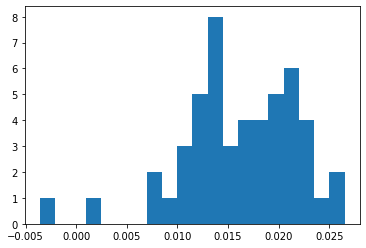

In [140]:
import pickle as pkl

predict_results  = pkl.load(open("results/sprint/predict_results_accord_baseline.pkl", 'rb'))

mean_ates = predict_results.mean(1)

print(mean_ates.mean(0), predict_results.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

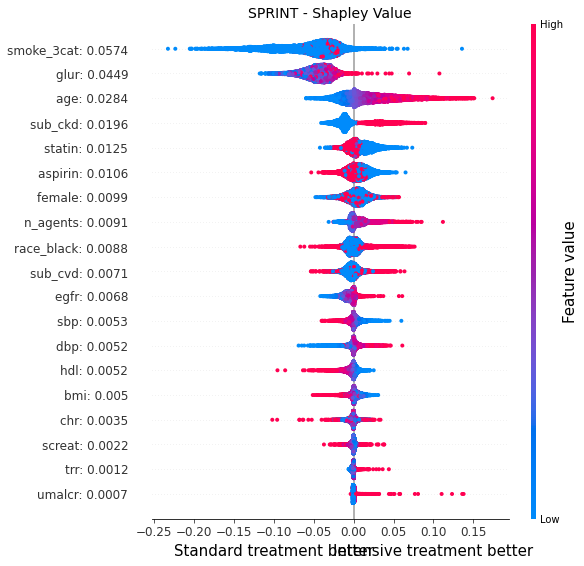

In [169]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/shap_bootstrapped_accord_baseline.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

(array([8095.,   26.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1240.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

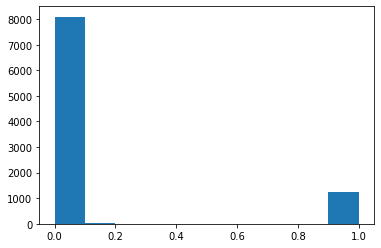

In [166]:
plt.hist(x[:, -5])

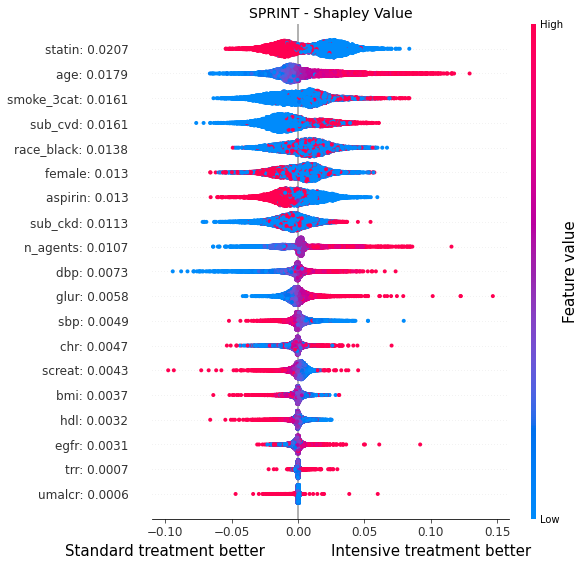

In [200]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/shap_bootstrapped.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

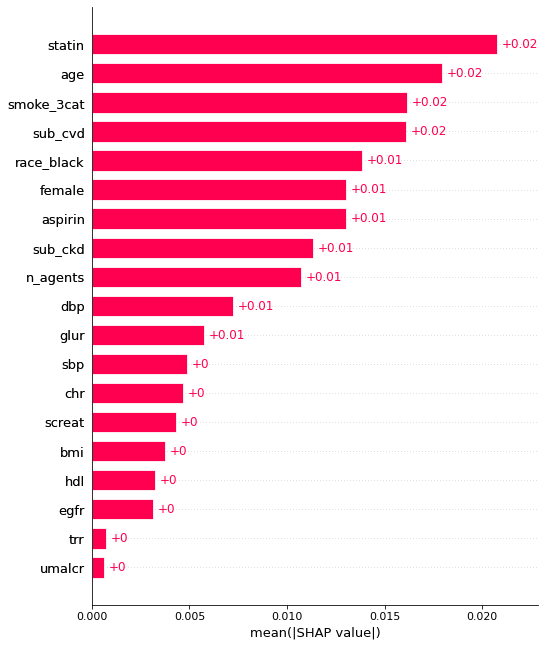

In [192]:
exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)


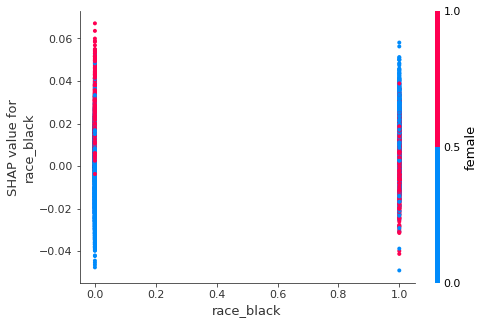

In [199]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

shap.dependence_plot(
    "race_black", 
     avg_shap.mean(0), 
     x_raw, 
     feature_names=data.get_feature_names(),
     # interaction_index="smoke_3cat"
)

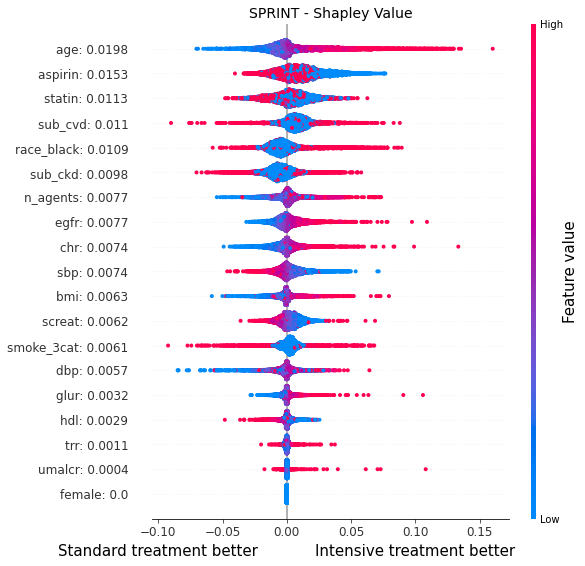

In [9]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/female=0.0_shap.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 0], 
    data.get_feature_names()
)

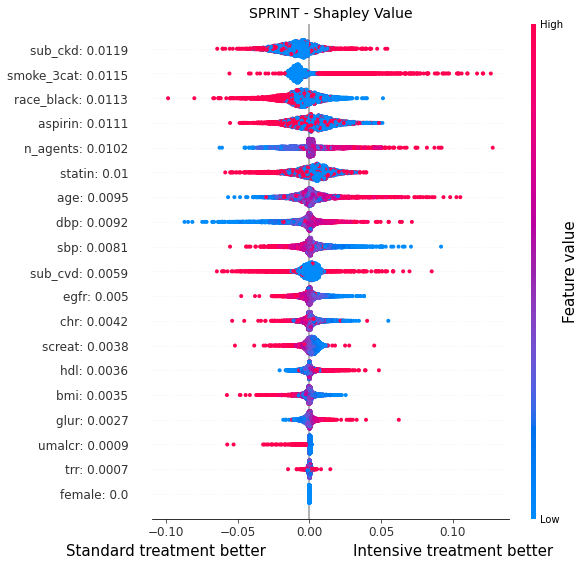

In [10]:
gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/female=1.0_shap.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 1], 
    data.get_feature_names()
)

Shapley Value Sampling attribution: 100%|███| 2001/2001 [02:52<00:00, 11.59it/s]


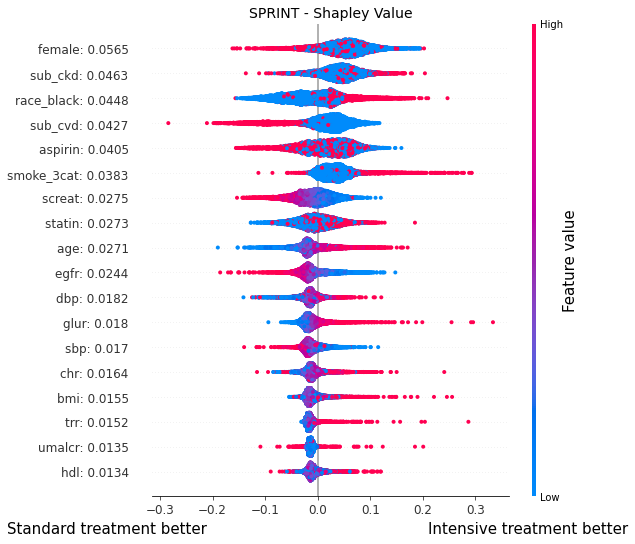

In [26]:
baseline = x.mean(0)

marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                baselines = torch.tensor(baseline.reshape(1,-1)),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, x, data.get_feature_names())

Shapley Value Sampling attribution: 100%|███| 2001/2001 [02:53<00:00, 11.51it/s]


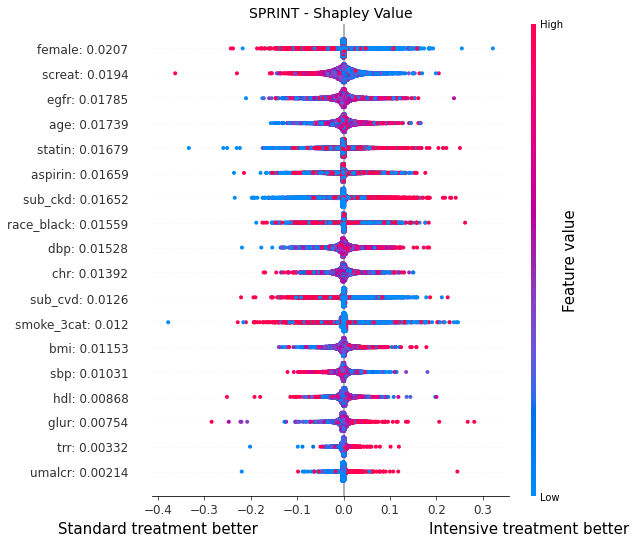

In [28]:
random_indices = np.random.choice(len(x), len(x), replace=True)

random_sampling_model = ShapleyValueSampling(model)

random_shapley_value = random_sampling_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                baselines = torch.tensor(x[random_indices ,:]),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(random_shapley_value, x, data.get_feature_names())

In [23]:
refe = torch.from_numpy(np.mean(x, axis=0).reshape(1,-1))

refe = x[np.random.choice(len(x), 2000, replace=False)]

explicand = x 

expl = shap.DeepExplainer(model, torch.from_numpy(refe))
attr = expl.shap_values(torch.from_numpy(explicand))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


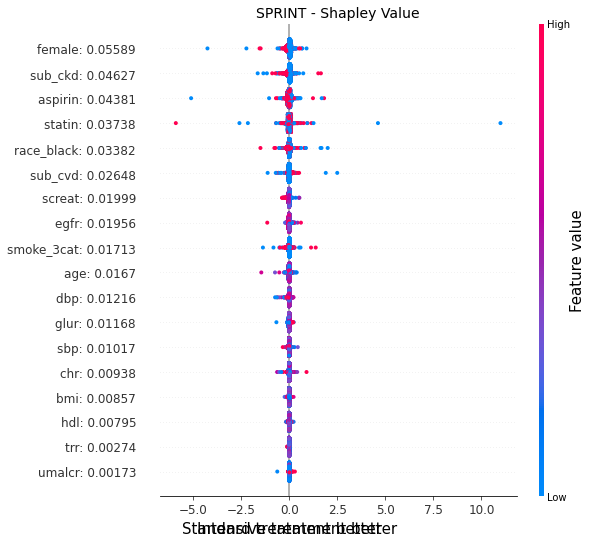

In [24]:
plot_feature_values(
    attr, 
    explicand, 
    data.get_feature_names()
)

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

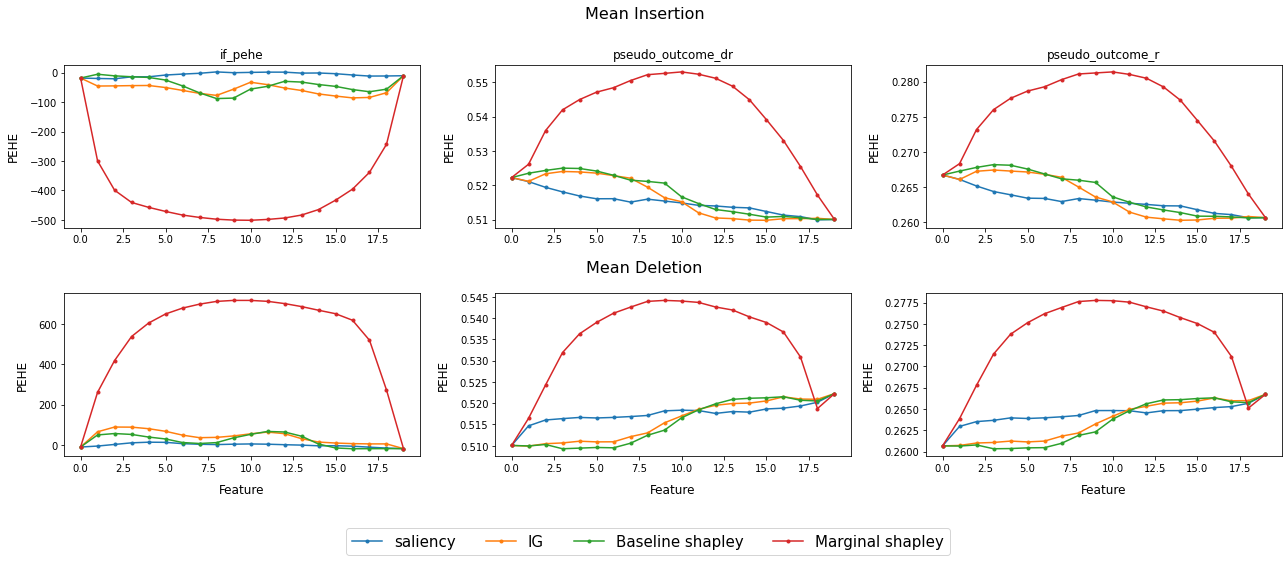

In [134]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

# Loop over the different files

seeds = [i for i in range(10)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/sprint/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])
            auroc_ate[exp].append(results[exp_index][4])
            
            auroc_full.append(results[exp_index][7])
            auroc_full_ate.append(results[exp_index][6])
            
            auroc_random.append(results[exp_index][9])
            auroc_random_ate.append(results[exp_index][8])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


0.011318615421024284 saliency
0.012226771035426073 integrated_gradients
0.012192908570655707 baseline_shapley_value_sampling
0.016946838224118747 marginal_shapley_value_sampling
0.5433263695431305 saliency
0.5540451386655768 integrated_gradients
0.5550196306020264 baseline_shapley_value_sampling
0.5934191682318246 marginal_shapley_value_sampling


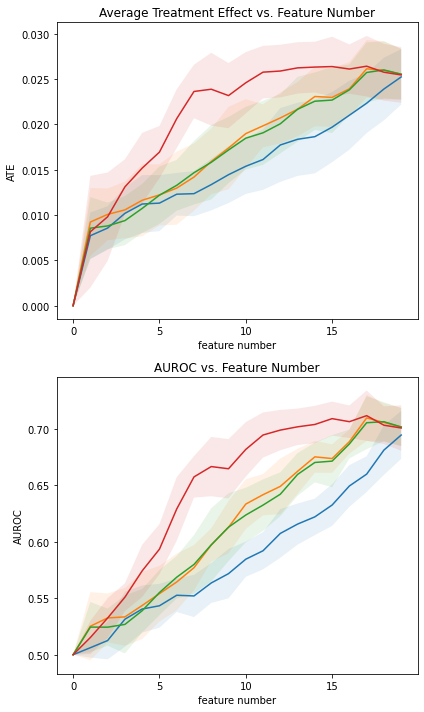

In [136]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

    

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))


# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    print(v[4], k)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 18, 5))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    print(v[4], k)

    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 18, 5))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.1))

plt.tight_layout()
plt.show()

average tx effect 0.016690042487909056
average tx effect 0.018357205202962627


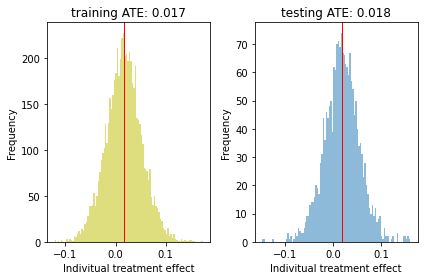

In [71]:
learner = "XLearner"
shuffle = "True"

results_train = pkl.load(open(f"results/sprint/train_shuffle_{shuffle}_{learner}.pkl", "rb"))
results_test = pkl.load(open(f"results/sprint/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

print("average tx effect", np.mean(results_train))
print("average tx effect", np.mean(results_test))

plt.subplot(1,2,1)
plt.hist(np.mean(results_train, axis=0), bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(results_train), linewidth=1, color='r')

plt.title("training ATE: "+ str(np.round(np.mean(results_train), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(np.mean(results_test, axis=0), bins=100, alpha = 0.5)
plt.axvline(x= np.mean(results_test), linewidth=1, color='r')

plt.title("testing ATE: "+ str(np.round(np.mean(results_test), 3)))
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()